In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y']
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X.reshape(X.shape[0], 50, 50, 1) / 255

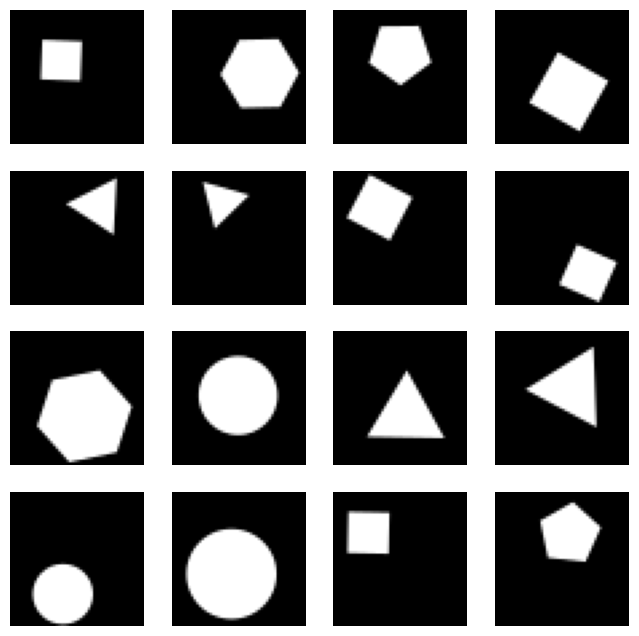

In [3]:
#Original data visualisation

data_generator = ImageDataGenerator()
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

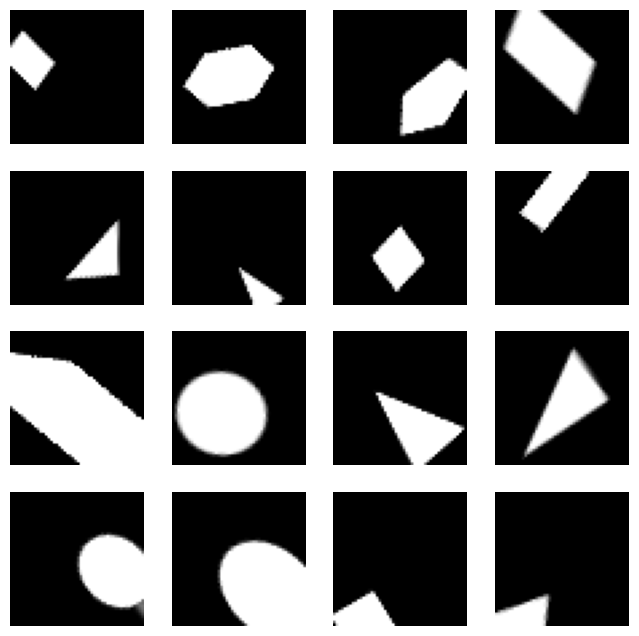

In [4]:
#Data augmentation visualisation

data_generator = ImageDataGenerator(
    rotation_range = 90,
    zoom_range = 0.2,
    shear_range = 45,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    channel_shift_range = 0.9,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

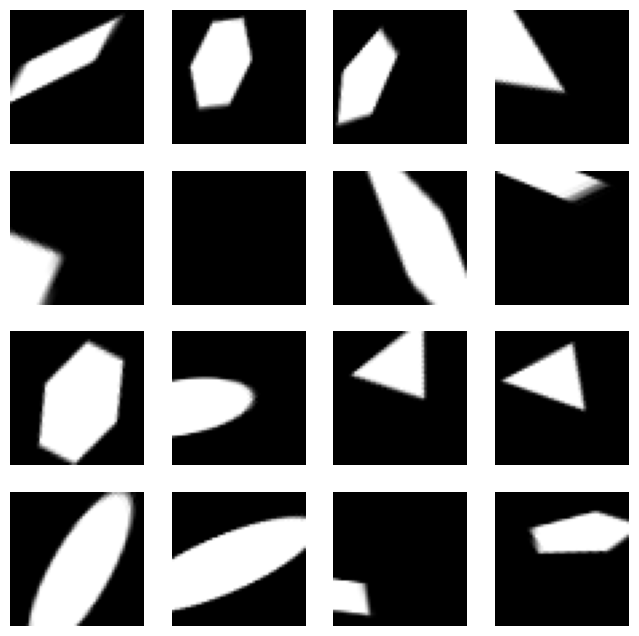

In [5]:
#Crazy data augment try

data_generator = ImageDataGenerator(
    rotation_range = 180,
    zoom_range = 0.5,
    shear_range = 70,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.25,
    width_shift_range = 0.25,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

In [6]:
X.shape

(10000, 50, 50, 1)

In [7]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

In [7]:
#TOP MODEL 99.48 ON ADVANCED

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(128, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 32, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 8, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/32, epochs = 200, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856 

250/250 [==============================] - 6s 22ms/step - loss: 0.2914 - accuracy: 0.9238 - val_loss: 0.2048 - val_accuracy: 0.9450
Epoch 91/200
250/250 [==============================] - 6s 22ms/step - loss: 0.2968 - accuracy: 0.9208 - val_loss: 0.1908 - val_accuracy: 0.9450
Epoch 92/200
250/250 [==============================] - 6s 23ms/step - loss: 0.2712 - accuracy: 0.9316 - val_loss: 0.1706 - val_accuracy: 0.9580
Epoch 93/200
250/250 [==============================] - 5s 22ms/step - loss: 0.2750 - accuracy: 0.9315 - val_loss: 0.2081 - val_accuracy: 0.9455
Epoch 94/200
250/250 [==============================] - 6s 22ms/step - loss: 0.2738 - accuracy: 0.9331 - val_loss: 0.2060 - val_accuracy: 0.9420
Epoch 95/200
250/250 [==============================] - 5s 22ms/step - loss: 0.2834 - accuracy: 0.9278 - val_loss: 0.1934 - val_accuracy: 0.9480
Epoch 96/200
250/250 [==============================] - 6s 22ms/step - loss: 0.2822 - accuracy: 0.9294 - val_loss: 0.1779 - val_accuracy: 0.947

<AxesSubplot: >

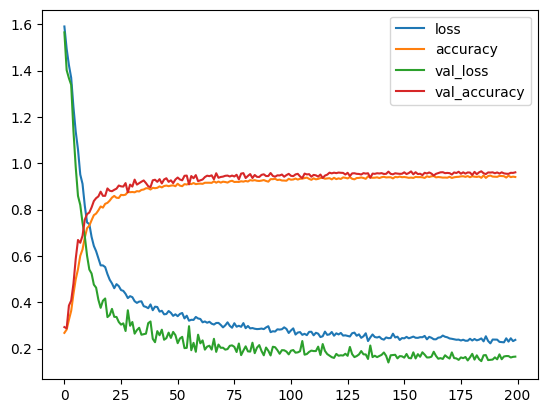

In [8]:
pd.DataFrame(hist.history).plot()

In [ ]:
#Tried other things

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 32, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 8, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/32, epochs = 200, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_70 (Conv2D)          (None, 50, 50, 64)        640       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 12, 12, 128)       738

250/250 [==============================] - 6s 22ms/step - loss: 0.3124 - accuracy: 0.9214 - val_loss: 0.2449 - val_accuracy: 0.9430
Epoch 84/200
250/250 [==============================] - 6s 22ms/step - loss: 0.3834 - accuracy: 0.8913 - val_loss: 0.2786 - val_accuracy: 0.9285
Epoch 85/200
250/250 [==============================] - 6s 22ms/step - loss: 0.3030 - accuracy: 0.9223 - val_loss: 0.2353 - val_accuracy: 0.9400
Epoch 86/200
250/250 [==============================] - 6s 23ms/step - loss: 0.3192 - accuracy: 0.9235 - val_loss: 0.2045 - val_accuracy: 0.9575
Epoch 87/200
250/250 [==============================] - 6s 23ms/step - loss: 0.2949 - accuracy: 0.9293 - val_loss: 0.1953 - val_accuracy: 0.9520
Epoch 88/200
250/250 [==============================] - 6s 22ms/step - loss: 0.3203 - accuracy: 0.9263 - val_loss: 0.2178 - val_accuracy: 0.9520
Epoch 89/200
250/250 [==============================] - 6s 22ms/step - loss: 0.2955 - accuracy: 0.9296 - val_loss: 0.3248 - val_accuracy: 0.917

In [75]:
#99.89%

inp = keras.layers.Input(shape = (50, 50, 1));
for i in range(1):
    out = keras.layers.Conv2D(32, kernel_size=(5, 5), padding = 'same', input_shape=[50, 50, 1])(inp);
    #out = keras.layers.BatchNormalization(axis = -1)(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(1):
    out = keras.layers.Conv2D(64, kernel_size=(4, 4), padding = 'same')(out);
    #out = keras.layers.BatchNormalization(axis = -1)(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    #out = keras.layers.BatchNormalization(axis = -1)(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    #out = keras.layers.BatchNormalization(axis = -1)(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
#out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(out);
#out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
#out = keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(out);
#out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 64, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 8, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/64, epochs = 20, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_199 (Conv2D)         (None, 50, 50, 32)        832       
                                                                 
 activation_199 (Activation)  (None, 50, 50, 32)       0         
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_200 (Conv2D)         (None, 25, 25, 64)        32832     
                                                                 
 activation_200 (Activation)  (None, 25, 25, 64)       0         
                                                          

In [10]:
inp = keras.layers.Input(shape = (50, 50, 1));
for i in range(1):
    out = keras.layers.Conv2D(8, kernel_size=(5, 5), padding = 'same', input_shape=[50, 50, 1])(inp);
    #out = keras.layers.BatchNormalization(axis = -1)(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.AveragePooling2D(pool_size=(2, 2))(out);
for i in range(1):
    out = keras.layers.Conv2D(16, kernel_size=(5, 5), padding = 'same')(out);
    #out = keras.layers.BatchNormalization(axis = -1)(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.AveragePooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(120, activation = 'relu')(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(84, activation = 'relu')(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 64, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 8, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/64, epochs = 20, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 8)         208       
                                                                 
 activation_4 (Activation)   (None, 50, 50, 8)         0         
                                                                 
 average_pooling2d_2 (Averag  (None, 25, 25, 8)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 16)        3216      
                                                                 
 activation_5 (Activation)   (None, 25, 25, 16)        0         
                                                           

In [ ]:
hist = model.fit(data_generator.flow(X, y, batch_size = 64, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 8, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/64, epochs = 50, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Epoch 1/50
125/125 [==============================] - 4s 33ms/step - loss: 0.8457 - accuracy: 0.6749 - val_loss: 0.7223 - val_accuracy: 0.7445
Epoch 2/50
125/125 [==============================] - 4s 31ms/step - loss: 0.8346 - accuracy: 0.6724 - val_loss: 0.6758 - val_accuracy: 0.7620
Epoch 3/50
125/125 [==============================] - 4s 32ms/step - loss: 0.8298 - accuracy: 0.6809 - val_loss: 0.7292 - val_accuracy: 0.7145
Epoch 4/50
125/125 [==============================] - 4s 32ms/step - loss: 0.8284 - accuracy: 0.6778 - val_loss: 0.7111 - val_accuracy: 0.7300
Epoch 5/50
125/125 [==============================] - 4s 32ms/step - loss: 0.8294 - accuracy: 0.6763 - val_loss: 0.7240 - val_accuracy: 0.7355
Epoch 6/50
125/125 [==============================] - 4s 32ms/step - loss: 0.8318 - accuracy: 0.6758 - val_loss: 0.7191 - val_accuracy: 0.7340
Epoch 7/50
125/125 [==============================] - 4s 32ms/step - loss: 0.8298 - accuracy: 0.6765 - val_loss: 0.7098 - val_accuracy: 0.7565